In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
import cv2

from mac0460_5832.utils import *

In [3]:
import pandas as pd
import pdb
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score
from time import time
from toolz import curry
from joblib import Parallel, delayed
from multiprocessing import cpu_count, Pool
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt

In [130]:
def find_center(a):
    """
    a: array
    """
    r = int(a.shape[0] / 2)
    c = int(a.shape[1] / 2)
    
    return (r, c)

def extract_window(image, W, stride=0):
    ### Zero Padding
    W_center = find_center(W)
    vertical_shift = (W.shape[0] - 1) - W_center[0]
    horizontal_shift = (W.shape[1] - 1) - W_center[1]
    pad_width = max([vertical_shift, horizontal_shift])
    im = np.pad(image, pad_width, mode="constant", constant_values=0)
    im = im * 1
        
    extracted = []
    for i in range(int(image.shape[0] / (stride + 1))):
        i += pad_width 
        i += i*stride
        for j in range(int(image.shape[1] / (stride + 1))):
            j += pad_width
            j += j*stride
            #pdb.set_trace()
            extracted.append((W * im[i-vertical_shift:i+vertical_shift+1, j-horizontal_shift:j+horizontal_shift+1]).astype(int))
                
    return extracted

def accuracy_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    accuracies = [np.sum(pair[0] == pair[1]) / len(pair[0].flatten()) for pair in pairs]
    return np.mean(np.array(accuracies))

def mse_score(y_true, y_pred):
    pairs = list(zip(y_true, y_pred))
    mses = [np.mean(np.power(pair[0] - pair[1], 2)) for pair in pairs]
    return np.mean(np.array(mses))

    return 0

def first_array(x):
    return list(x[0])
    
def train_w(I, O, W_shape, operator=[], stride=0, verbose=True, multiproc=False):
    """
    I: list of input images
    O: list of output images
    W_shape: window shape
    """
    if len(operator) == 0:
        W = np.ones(W_shape)
    else:
        W = operator
        
    ###
    if multiproc:
        pass
    else:
        list_of_patterns = [extract_window(i.astype(int), W, stride) for i in I]
        X_train = [pattern for patterns in list_of_patterns for pattern in patterns]
        
        list_of_labels = [extract_window(o.astype(int), np.ones((1,1))) for o in O]
        y_train = [label for labels in list_of_labels for label in labels]
        
    ### Multiply X_train by W considering the 1s and 0s
#     if len(operator) == 0:
#         X_train = [pattern * operator for pattern in X_train]
        
    start = time()
    ### Fit
    df = pd.DataFrame()
    df["pattern"] = X_train
    df["array"] = X_train
    df["y"] = y_train
    df["y"] = df["y"].apply(lambda x : x[0][0])
    df["pattern"] = df["pattern"].apply(lambda x : str(x.astype(int)))    
    threshold = np.mean(y_train)
    f = df.groupby("pattern", as_index=False).agg({"y": "mean", "array": lambda x : list(x)})
    f["array"] = f["array"].apply(lambda x : x[0])
    
    
    f["y"] = (f["y"] > threshold) * 1 
    
    
    if verbose:
        print('Fitting: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    start = time()
    ### Predict
    y_pred = [predict(f, im, W) for im in I]   
    if verbose:
        print('Predict: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    ### Friendly format to calc the metrics
    y_true = [y[0][0] for y in y_train]
    y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]

    start = time()
    ### metrics to log
    accuracy = accuracy_score(O, y_pred)    
    precision = precision_score(y_true, y_hat)
    recall = recall_score(y_true, y_hat)
    mse = mse_score(O, y_pred)    
    f1 = f1_score(y_true, y_hat)
    if verbose:
        print('Metrics: {0}m{1}s'.format(int((time()-start)/60), int((time()-start)%60 )))        
    
    logs = {}
    logs["accuracy"] = accuracy
    logs["mse"] = mse    
    logs["precision"] = precision
    logs["recall"] = recall
    logs["f1"] = f1
    
    if verbose:
        print("Training metrics: ")
        print("Threshold: {:.2f}".format(threshold))
        print("Accuracy: {:0.2f}".format(accuracy))    
        print("Precision: {:0.2f}".format(precision))
        print("Recall: {:0.2f}".format(recall))
        print("MSE: {:0.2f}".format(mse))
        print("F1: {:0.2f}".format(f1))
    
    return X_train, y_train, f, logs

def learning_curve(I, O, W_shape, T, operator=[], stride=0, verbose=False, multiproc=False):
    
    train_errors = []
    test_errors = []
    for i in tqdm_notebook(range(1, len(I))):
        train_images = I[:i]
        train_output = O[:i]
        X_train, y_train, f, logs = train_w(train_images, train_output, w.shape, operator, verbose=verbose)
        
        train_errors.append(1 - logs["accuracy"])

        ### Test error
        y_pred = [predict(f, im, operator) for im in T]   
        y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        accuracy = accuracy_score(O, y_pred)
        test_errors.append(1 - accuracy)
        
    plt.plot(train_errors, label="Ein")
    plt.plot(test_errors, label="Eout")
    plt.title("Learning Curve")
    plt.xlabel("Number of training images")
    plt.ylabel("Percentage of incorrect predicted pixels")
    plt.legend()
    plt.show()
    
def learning_curve_multiresolution(I, O, windows, T, operator=[], stride=0, verbose=False, multiproc=False):
    train_errors = []
    test_errors = []
    for i in tqdm_notebook(range(1, len(I))):
        train_images = I[:i]
        train_output = O[:i]
        
        functions = []
        for window in windows:
            X_train, y_train, f, logs = train_w(train_images, train_output, window.shape, window, verbose=verbose)
            functions.append(f)
    
        y_pred = [multiresolution_predict(functions, im, windows) for im in train_images]   
        #y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        train_accuracy = accuracy_score(train_output, y_pred)
#         if train_accuracy == np.nan:
#             train_accuracy = 1
            
        train_errors.append(1 - train_accuracy)

        ### Test error
        y_pred = [multiresolution_predict(functions, im, windows) for im in T]   
        #y_hat = [x for p in [y for y_p in y_pred for y in y_p] for x in p]
        
        test_accuracy = accuracy_score(O[:len(T)], y_pred)
        test_errors.append(1 - test_accuracy)
        
    plt.plot([i for i in range(1, len(train_errors) + 1)], train_errors, label="Ein")
    plt.plot([i for i in range(1, len(test_errors) + 1)], test_errors, label="Eout")
    plt.title("Learning Curve")
    plt.xlabel("Number of training images")
    plt.ylabel("Percentage of incorrect predicted pixels")
    plt.legend()
    plt.show()
    
    return train_errors, test_errors
    
def retrieve_prediction(f, pattern):
    try:
        prediction = f[f["pattern"] == str(pattern)]["y"].values[0]
    except:
        prediction = 0
        
    return prediction
                        
def predict(f, image, W):
    """
    
    """
    extracted_feats = extract_window(image, W)    

    ### Multiproc
    partitions = cpu_count()
    result = Parallel(n_jobs= partitions, max_nbytes=None)(delayed(retrieve_prediction)(f, pattern) for pattern in extracted_feats)

    ### Single thread
    #result = [retrieve_prediction(f, feat) for feat in extracted_feats]    
    
    output = np.array(result).reshape(image.shape)
    
    return output

def retrieve_multiresolution_prediction(functions, extracted_feats, i):
    prediction = None
    for i, function in enumerate(functions):
        try:
            prediction = function[function["pattern"] == str(extracted_feats[i][pixel])]["y"].values[0]                
            break
        except:
            pass
    if prediction == None:
        prediction = 0
        
    return prediction


def multiresolution_predict(functions, image, windows):
    output = np.zeros(image.shape)
    result = []
    extracted_feats = [extract_window(image, W) for W in windows]
    
    ### Multiproc
    partitions = cpu_count()
    result = Parallel(n_jobs= partitions, max_nbytes=None)(delayed(retrieve_multiresolution_prediction)(functions, extracted_feats, pixel) for pixel in range(np.size(image)))
  
    return np.array(result).reshape(image.shape)

def multiresolution_predict_single(functions, image, windows):
    output = np.zeros(image.shape)
    result = []
    extracted_feats = [extract_window(image, W) for W in windows]
        
    for pixel in range(np.size(image)):
        prediction = None
        for i, function in enumerate(functions):
            try:
                prediction = function[function["pattern"] == str(extracted_feats[i][pixel])]["y"].values[0]                
                break
            except:
                pass
        if prediction == None:
            prediction = 0
        result.append(prediction)
                                      
    return np.array(result).reshape(image.shape)

def print_patterns(patterns):    
    for pattern in patterns:
        draw_img(pattern)
        
        
def custom_apply(I, O, kernel_1, kernel_2, f_1, f_2):
    train_errors = []
    test_errors = []

    I_2 = [f_1(img, kernel_1, iterations= 1) for img in I]
    final = [f_2(img, kernel_2, iterations= 1) for img in I_2]

    train_error = [1 - accuracy_score(O[0], img) for img in final]
    train_error = sum(train_error) / float(len(train_error))
    
    return train_error, final

def opening_closing(I, O, w1, w2, opening=True, closing=False):    
    if opening and not closing:
        f_1 = cv2.erode
        f_2 = cv2.dilate
        error, final = custom_apply(train_images, train_output, w1, w2, f_1, f_2)
    
    if closing and not opening:
        f_1 = cv2.dilate
        f_2 = cv2.erode
        error, final = custom_apply(train_images, train_output, w1, w2, f_1, f_2)

    if opening and closing:
        f_1 = cv2.erode
        f_2 = cv2.dilate
        
        error, final = custom_apply(train_images, train_output, w1, w2, f_1, f_2)
        error, final = custom_apply(final, train_output, w1, w2, f_2, f_1)
        
    return error, final

# MAC0460/5832 - Lista 2: Escolha de modelo

### Data de Entrega: 23h55m do dia 22/10/2018

(Ainda sem monitoria definida)

Q1. Projete, a partir dos dados, o operador capaz de filtrar ruído usando a técnica de multiresolução. Como conjuntos de hipóteses, utilize diferentes subamostragens da janela original, como ilustrado abaixo:

1. Subamostragem 1: ![alt text](imgs/q1_h1.png "1")
2. Subamostragem 2: ![alt text](imgs/q1_h2.png "2")
3. Subamostragem 3: ![alt text](imgs/q1_h3.png "2")

Para cada conjunto, plote os erros  $E_{in}$ e $E_{val}$ ao longo do treinamento. Após escolher o modelo mais apropriado, retreine seu operador com todos os dados e imprima o erro $E_{in}$.

Utilize as imagens da pasta imgs/q1/ para realizar o treinamento e validação (nota: são as mesmas imagens do EP anterior).

In [133]:
n_train = 10
train_images = [read_img("imgs/q1/q1_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("imgs/q1/q1_dest.png") for i in range(1, n_train+1)]

In [134]:
train_images[:1]

[array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])]

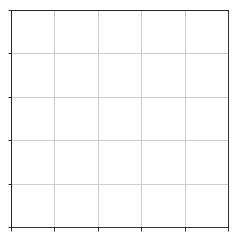

In [135]:
w1 = np.ones((5, 5), dtype=int)
#w1 = np.array([[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1] , [1, 1, 1, 1, 1]])
draw_img(w1)

### Deveria aparecer todo escuro, mas quando é tudo 1 ele fica branco.
### Se eu tiro um 1 e substituo por 0 ele fica com todos em preto, 
### menos um.

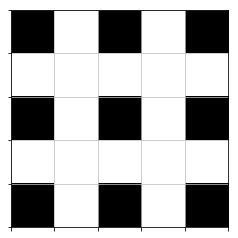

In [136]:
w2 = np.array([[1, 0, 1, 0, 1], [0, 0, 0, 0, 0], [1, 0, 1, 0, 1], [0, 0, 0, 0, 0] , [1, 0, 1, 0, 1]])
draw_img(w2)

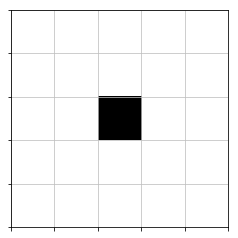

In [137]:
w3 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0] , [0, 0, 0, 0, 0]])
draw_img(w3)

### Subamostragem 1

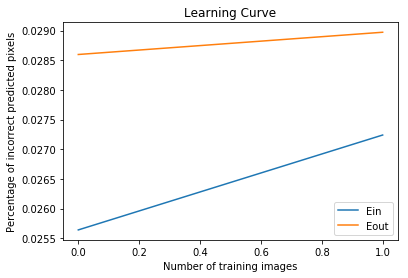

([0.025640624999999972, 0.027240234375000005],
 [0.028597656249999992, 0.028972656250000006])

In [8]:
windows = [w1, w2, w3]

ein_1, eout_1 = learning_curve_multiresolution(train_images[:4], train_output[:4], windows, train_images[9:], operator=[], stride=0, verbose=False, multiproc=False)

In [138]:
train_images = [read_img("imgs/q1/q1_src" + str(i) + ".png") for i in range(1, n_train+1)]
train_output = [read_img("imgs/q1/q1_dest.png") for i in range(1, n_train+1)]

In [139]:
train_images[0].shape

(400, 640)

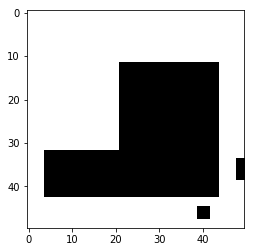

In [140]:
draw_img(train_images[0][150:200, 150:200])

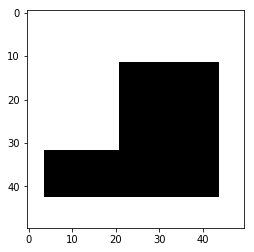

In [141]:
draw_img(train_output[0][150:200, 150:200])

In [73]:
train_images = [im[150:300, 150:300] for im in train_images]
train_output = [im[150:300, 150:300] for im in train_output]

ValueError: x and y must have same first dimension, but have shapes (8,) and (7,)

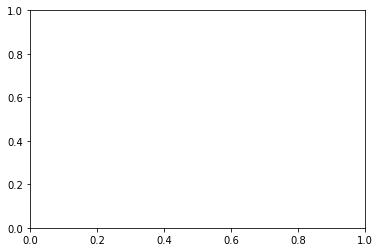

In [74]:
windows = [w1, w2, w3]

ein_1, eout_1 = learning_curve_multiresolution(train_images[:8], train_output[:8], windows, train_images[8:], operator=[], stride=0, verbose=False, multiproc=False)

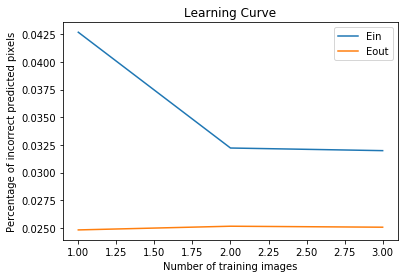

In [87]:
ein_1, eout_1 = learning_curve_multiresolution(train_images[:4], train_output[:4], windows, train_images[4:], operator=[], stride=0, verbose=False, multiproc=False)

In [90]:
ein_1

[0.04266666666666663, 0.03222222222222215, 0.03198518518518512]

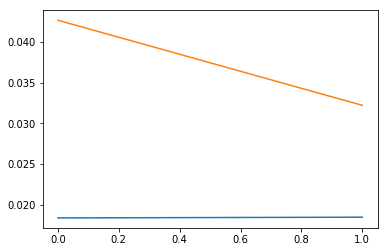

In [80]:
plt.plot(eout_1)
plt.plot(ein_1)

### Subamostragem 2

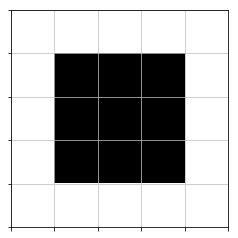

In [142]:
w2 = np.array([[0, 0, 0, 0, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0], [0, 1, 1, 1, 0] , [0, 0, 0, 0, 0]])
draw_img(w2)

> <ipython-input-130-53b6433fd9f7>(159)learning_curve_multiresolution()
-> train_images = I[:i]
(Pdb) n
> <ipython-input-130-53b6433fd9f7>(160)learning_curve_multiresolution()
-> train_output = O[:i]
(Pdb) n
> <ipython-input-130-53b6433fd9f7>(162)learning_curve_multiresolution()
-> functions = []
(Pdb) n
> <ipython-input-130-53b6433fd9f7>(163)learning_curve_multiresolution()
-> for window in windows:
(Pdb) n
> <ipython-input-130-53b6433fd9f7>(164)learning_curve_multiresolution()
-> X_train, y_train, f, logs = train_w(train_images, train_output, window.shape, window, verbose=verbose)
(Pdb) n

> <ipython-input-130-53b6433fd9f7>(165)learning_curve_multiresolution()
-> functions.append(f)
(Pdb) X_train.shape
*** AttributeError: 'list' object has no attribute 'shape'
(Pdb) len(X_train)
256000
(Pdb) len(f)
843
(Pdb) f.shape
(843, 3)
(Pdb) c
> <ipython-input-130-53b6433fd9f7>(158)learning_curve_multiresolution()
-> import pdb;pdb.set_trace()
(Pdb) l
153  	
154  	def learning_curve_multiresolu

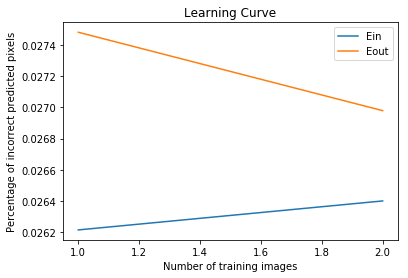

In [143]:
windows = [w1, w2, w3]
ein_2, eout_2 = learning_curve_multiresolution(train_images[2:5], train_output[2:5], windows, train_images[:2], operator=[], stride=0, verbose=False, multiproc=False)

### Subamostragem 3

In [88]:
w2 = np.array([[0, 0, 1, 0, 0], [0, 1, 1, 1, 0], [1, 1, 1, 1, 1], [0, 1, 1, 1, 0] , [0, 0, 1, 0, 0]])
w3 = np.array([[0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 1, 1, 1, 0], [0, 0, 1, 0, 0] , [0, 0, 0, 0, 0]])
w4 = np.array([[0, 0, 0, 0, 0], [0, 0, 0, 0, 0], [0, 0, 1, 0, 0], [0, 0, 0, 0, 0] , [0, 0, 0, 0, 0]])

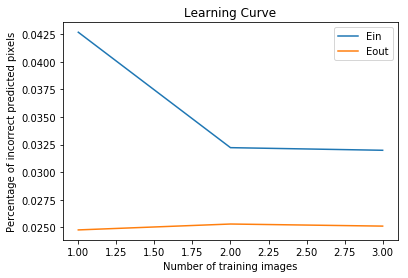

In [89]:
windows = [w1, w2, w3, w4]
ein_3, eout_3 = learning_curve_multiresolution(train_images[:4], train_output[:4], windows, train_images[4:], operator=[], stride=0, verbose=False, multiproc=False)

Q2. Considere novamente o problema de filtrar ruído. Utilizando as imagens da pasta imgs/q2/, explore diferentes funções booleanas para filtrar ruído. A operação **abertura** é definida como uma **erosão** seguida por uma **dilatação**, isto é $\delta_{B2}\epsilon_{B1}$, onde $B1$ e $B2$ são os elementos estruturantes. De modo semelhante, a função **fechamento** é definida por uma **dilatação** seguida por uma **erosão** ($\epsilon_{B2}\delta_{B1}$). Baseado nas funções *erosion* e *dilation* definidas em mac0460_5832/utils.py, teste os seguintes espaços de hipóteses:

1. Abertura;
2. Fechamento;
3. Abertura seguida de fechamento;

Para cada espaço de hipóteses, defina diferentes funções variando $B1$ e $B2$ (ou seja, crie as funções de maneira análoga à seguinte definição para um conjunto de aberturas: $\mathcal{F} = \{\psi_{B1B2}: \psi =  \delta_{B2}\epsilon_{B1}, B1, B2 \subseteq W_{3x3} \}$, onde $W_{3x3}$ é a janela 3x3). Mostre a função que tem menor erro e verifique o seu desempenho nos dados de teste.

Obs: existe no utils.py funções para abertura e fechamento. No entanto, essas funções utilizam o mesmo elemento estruturante para a erosão e dilatação, não permitindo o uso de diferentes elementos estruturantes. 

### Resolução

1. Definir os elementos estruturantes (kernel) possíveis a serem usados como B1 e B2 (foram usadas metade das janelas possíveis);
2. Testar os 3 espaços de hipótese com todas as combinações de B1 e B2;
3. Selecionar o que apresentar o menor erro e aplicar em uma imagem não usada no cálculo deste (uma de teste).

In [112]:
n_train = 4
train_images = [cv2.imread("imgs/q2/src" + str(i) + ".png") for i in range(0, n_train+1)]
train_output = [cv2.imread("imgs/q2/dest.png") for i in range(1, n_train+1)]

In [113]:
bs = [np.array(element) for element in list(itertools.product(list(itertools.product([0, 1], repeat=3)), repeat=3))]

In [114]:
### Exclude structuring elements with zero-center
# bs = [b for b in bs if b[2, 2] != 0]

bs = [b for i, b in enumerate(bs) if i % 2 == 0]
bs = [b for b in bs if np.sum(b) != 0]

In [115]:
import itertools
combinations = list(itertools.product(bs, repeat=2))
#combinations = combinations[:5000]
len(combinations)

65025

### Test images

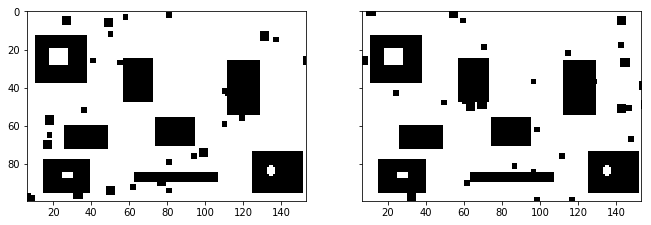

In [116]:
draw_img_pair(read_img('imgs/q2/test0.png'), read_img('imgs/q2/test1.png'), figsz=(11, 3.5))

#### 1. Opening

In [117]:
from time import time
start = time()
errors = []
for comb in combinations:
    error, result = opening_closing(train_images, train_output, opening=True, closing=False, w1=comb[0], w2=comb[0])
    errors.append(error)
    
argmin = np.argmin(np.array(errors)) 
opening_error = errors[argmin]
opening_ws = combinations[argmin]

In [118]:
print("Min error with opening: {}".format(opening_error))
print("Finish in : {:.2f} minutes".format((time() - start)/60.0))

Min error with opening: 0.02009999999999996
Finish in : 4.48 minutes


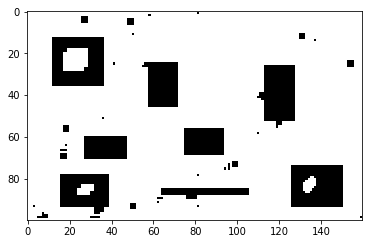

0.06250000000000011


In [119]:
img = cv2.imread('imgs/q2/test0.png', 0)
erosion = cv2.erode(img, opening_ws[0], iterations = 1)
dilate = cv2.dilate(erosion , opening_ws[1], iterations = 1)
draw_img(dilate)

print(1 - accuracy_score(img, dilate))

#### 2. Closing

In [120]:
errors = []
for comb in combinations:
    error, result = opening_closing(train_images, train_output, opening=False, closing=True, w1=comb[0], w2=comb[0])
    errors.append(error)
    
argmin = np.argmin(np.array(errors)) 
closing_error = errors[argmin]
closing_ws = combinations[argmin]

In [121]:
print("Min error with closing: {}".format(closing_error))

Min error with closing: 0.024649999999999995


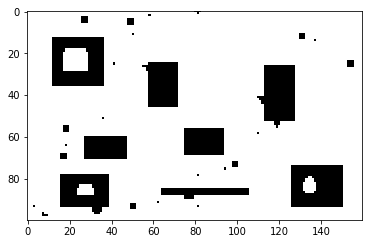

0.06262500000000004


In [122]:
img = cv2.imread('imgs/q2/test0.png', 0)
dilate = cv2.dilate(img, closing_ws[1], iterations = 1)
erosion = cv2.erode(dilate, closing_ws[0], iterations = 1)
draw_img(erosion)

print(1 - accuracy_score(img, erosion))

#### 3. Opening + Closing

In [123]:
errors = []
for comb in combinations:
    error, result = opening_closing(train_images, train_output, opening=True, closing=True, w1=comb[0], w2=comb[0])
    errors.append(error)
    
argmin = np.argmin(np.array(errors)) 
opening_closing_error = errors[argmin]
opening_closing_ws = combinations[argmin]

In [124]:
print("Min error with opening-closing: {}".format(opening_closing_error))

Min error with opening-closing: 0.01978750000000007


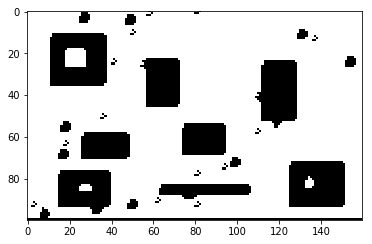

0.07837500000000008


In [125]:
img = cv2.imread('imgs/q2/test0.png', 0)
erosion = cv2.erode(img, opening_closing_ws[0], iterations = 1)
dilate = cv2.dilate(erosion, opening_closing_ws[1], iterations = 1)

dilate = cv2.dilate(dilate, opening_closing_ws[0], iterations = 1)
erosion = cv2.erode(dilate, opening_closing_ws[1], iterations = 1)

draw_img(erosion)
print(1 - accuracy_score(cv2.imread('imgs/q2/dest.png', 0), erosion))

### Best result

Os resultados foram consistentes: o erro de treinamento foi maior que o erro de teste em todos os casos. 

Porém, obsevamos que o menor erro de treinamento não fi aquele que gerou o menor erro no teste. Abaixo são colocadas as imagens originais, pós aplicação do melhor filtro no treinamento e o erro gerado.

### 1. Opening: Test results

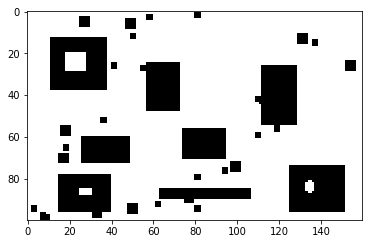

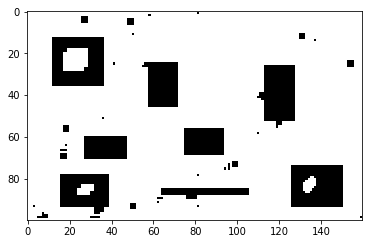

0.06250000000000011


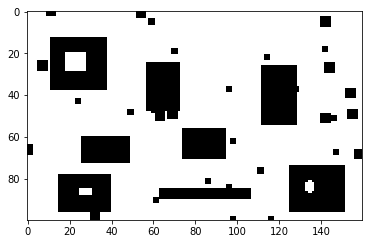

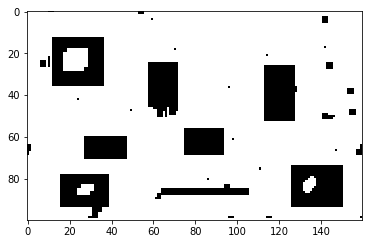

0.06362499999999993


In [126]:
img = cv2.imread('imgs/q2/test0.png', 0)
erosion = cv2.erode(img, opening_ws[0], iterations = 1)
dilate = cv2.dilate(erosion , opening_ws[1], iterations = 1)
draw_img(img)
draw_img(dilate)
print(1 - accuracy_score(img, dilate))

img = cv2.imread('imgs/q2/test1.png', 0)
erosion = cv2.erode(img, opening_ws[0], iterations = 1)
dilate = cv2.dilate(erosion , opening_ws[1], iterations = 1)
draw_img(img)
draw_img(dilate)
print(1 - accuracy_score(img, dilate))

### 2. Opening + Closing: Test images

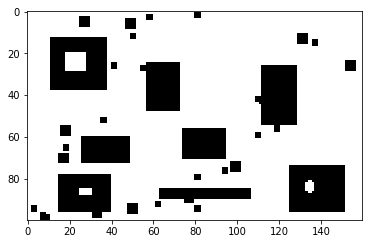

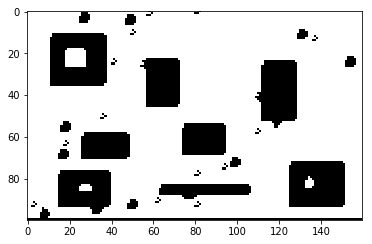

0.07837500000000008


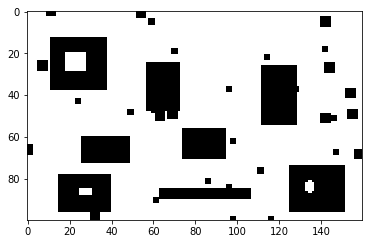

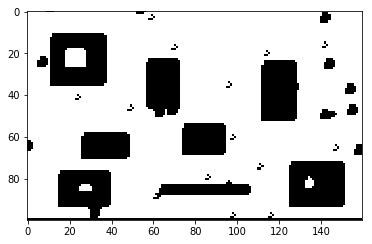

0.07906250000000004


In [127]:
img = cv2.imread('imgs/q2/test0.png', 0)
erosion = cv2.erode(img, opening_closing_ws[0], iterations = 1)
dilate = cv2.dilate(erosion, opening_closing_ws[1], iterations = 1)

dilate = cv2.dilate(dilate, opening_closing_ws[0], iterations = 1)
erosion = cv2.erode(dilate, opening_closing_ws[1], iterations = 1)

draw_img(img)
draw_img(erosion)
print(1 - accuracy_score(cv2.imread('imgs/q2/dest.png', 0), erosion))


img = cv2.imread('imgs/q2/test1.png', 0)
erosion = cv2.erode(img, opening_closing_ws[0], iterations = 1)
dilate = cv2.dilate(erosion, opening_closing_ws[1], iterations = 1)

dilate = cv2.dilate(dilate, opening_closing_ws[0], iterations = 1)
erosion = cv2.erode(dilate, opening_closing_ws[1], iterations = 1)

draw_img(img)
draw_img(erosion)
print(1 - accuracy_score(cv2.imread('imgs/q2/dest.png', 0), erosion))

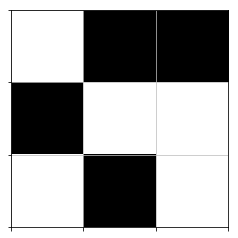

In [128]:
draw_img(opening_closing_ws[0])

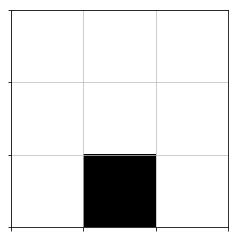

In [129]:
draw_img(opening_closing_ws[1])